In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scvi

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"

In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
SLN_206_adata = sc.read(f"{save_path}/spleen_lymph_206.h5ad")
SLN_111_adata = sc.read(f"{save_path}/spleen_lymph_111.h5ad")

In [3]:
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in SLN_111_adata.uns["protein_names"]]
)
SLN_111_adata.obsm["protein_expression"] = SLN_111_adata.obsm["protein_expression"][
    :, keep_pro_111
]
SLN_111_adata.uns["protein_names"] = SLN_111_adata.uns["protein_names"][keep_pro_111]

In [4]:
keep_pro_206 = np.array(
    [not p.startswith("HTO") for p in SLN_206_adata.uns["protein_names"]]
)
SLN_206_adata.obsm["protein_expression"] = SLN_206_adata.obsm["protein_expression"][
    :, keep_pro_206
]
SLN_206_adata.uns["protein_names"] = SLN_206_adata.uns["protein_names"][keep_pro_206]

In [29]:
rna_data_111 = ad.AnnData(
    X=SLN_111_adata.X,
    obs=SLN_111_adata.obs,
    var=pd.DataFrame(index=SLN_111_adata.var.index),
)
rna_data_111.obs['n_counts']  = rna_data_111.X.sum(axis=1)
rna_data_111.obs['panel']  = '111'
rna_data_111.obs_names = 'p111_'+rna_data_111.obs_names

In [30]:
rna_data_206 = ad.AnnData(
    X=SLN_206_adata.X,
    obs=SLN_206_adata.obs,
    var=pd.DataFrame(index=SLN_206_adata.var.index),
)
rna_data_206.obs['n_counts']  = rna_data_206.X.sum(axis=1)
rna_data_206.obs['panel']  = '206'
rna_data_206.obs_names = 'p206_'+rna_data_206.obs_names

In [82]:
protein_data_111 = ad.AnnData(
    X=np.array(SLN_111_adata.obsm["protein_expression"]),
    obs=SLN_111_adata.obs.copy(),
    var=SLN_111_adata.uns["protein_names"].copy()
)
protein_data_111.var_names = SLN_111_adata.uns["protein_names"]
protein_data_111.var = protein_data_111.var.drop(columns=0)
protein_data_111.obs['n_counts']  = protein_data_111.X.sum(axis=1)
protein_data_111.obs['panel']  = '111'
protein_data_111.obs_names = 'p111_'+protein_data_111.obs_names

In [83]:
protein_data_206 = ad.AnnData(
    X=np.array(SLN_206_adata.obsm["protein_expression"]),
    obs=SLN_206_adata.obs.copy(),
    var=SLN_206_adata.uns["protein_names"].copy()
)
protein_data_206.var_names = SLN_206_adata.uns["protein_names"]
protein_data_206.var = protein_data_206.var.drop(columns=0)
protein_data_206.obs['n_counts']  = protein_data_206.X.sum(axis=1)
protein_data_206.obs['panel']  = '206'
protein_data_206.obs_names = 'p206_'+protein_data_206.obs_names

In [33]:
# merge the rna adata of the two datasets
rna_adata_pool = ad.concat([rna_data_111, rna_data_206], join="outer", axis=0)

In [34]:
protein_adata_pool = ad.concat([protein_data_111, protein_data_206], join="outer", axis=0)

In [85]:
protein_adata_intersect = ad.concat([protein_data_111, protein_data_206], join="inner", axis=0)
protein_adata_intersect 

AnnData object with n_obs × n_vars = 32648 × 110
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'

In [35]:
rna_adata_pool

AnnData object with n_obs × n_vars = 32648 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'

# Preprocess

In [86]:
mdata = mu.MuData({
    "rna": rna_adata_pool,
    "protein": protein_adata_intersect,
})

In [37]:
rna_adata_pool.var['mt'] = rna_adata_pool.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata_pool, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

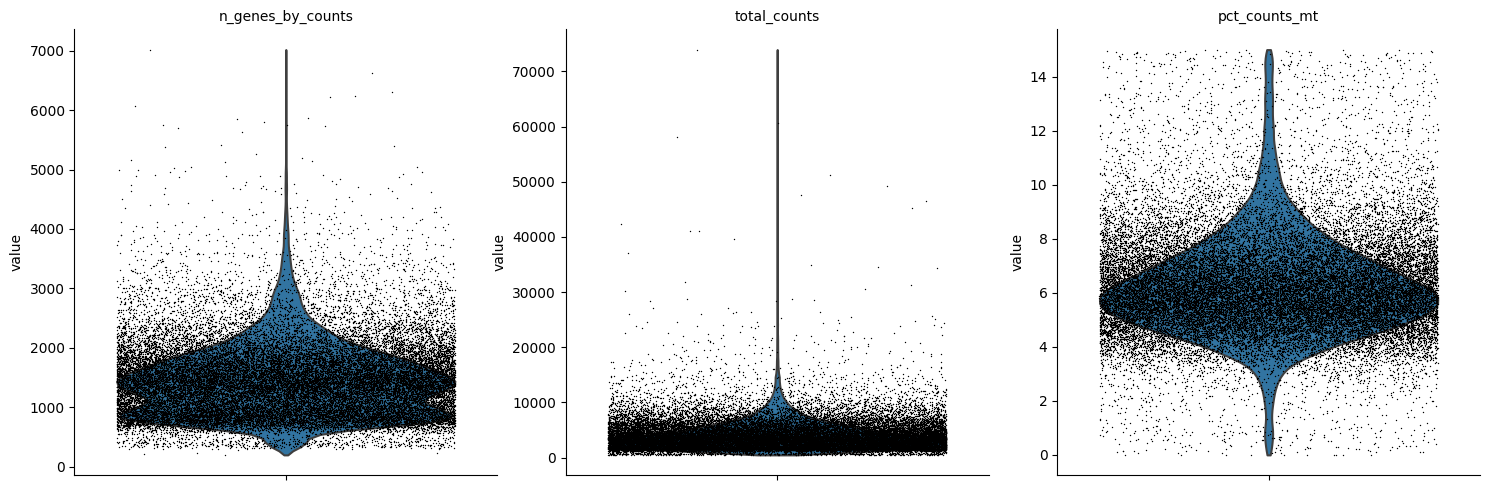

In [38]:
sc.pl.violin(rna_adata_pool, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [39]:
rna_adata_pool.layers["counts"] = rna_adata_pool.X.copy()

In [40]:
sc.pp.normalize_total(rna_adata_pool, target_sum=1e4)
sc.pp.log1p(rna_adata_pool)
rna_adata_pool.obs_names_make_unique()

In [41]:
sc.pp.highly_variable_genes(
    rna_adata_pool,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch_indices",
    layer="counts",
)

In [42]:
sc.tl.pca(rna_adata_pool, svd_solver='arpack')
sc.pp.neighbors(rna_adata_pool, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna_adata_pool, resolution=.75)
sc.tl.umap(rna_adata_pool, spread=1., min_dist=.5, random_state=42)

In [43]:
rna_adata_pool.write_h5ad(f"{save_path}/rna_pool.h5ad")

In [44]:
protein_adata_pool.layers["counts"] = protein_adata_pool.X.copy()
# sc.pp.normalize_total(protein_adata_pool, target_sum=1e4)
# sc.pp.log1p(protein_adata_pool)

In [45]:
protein_adata_pool.layers["counts"] = np.nan_to_num(protein_adata_pool.layers["counts"], nan=0.0)
protein_adata_pool.X = protein_adata_pool.layers["counts"].copy()
sc.pp.normalize_total(protein_adata_pool, target_sum=1e4)
sc.pp.log1p(protein_adata_pool)

In [46]:
protein_adata_pool.write_h5ad(f"{save_path}/protein_pool.h5ad")

In [87]:
# protein_adata_intersect.layers["counts"] = np.nan_to_num(protein_adata_intersect.layers["counts"], nan=0.0)
protein_adata_intersect.X = np.nan_to_num(protein_adata_intersect.X, nan=0.0)
sc.pp.normalize_total(protein_adata_intersect, target_sum=1e4)
sc.pp.log1p(protein_adata_intersect)

In [88]:
protein_adata_intersect.write(f"{save_path}/scCITE_intersect_protein.h5ad")
mdata.write_h5mu(f"{save_path}/scCITE_intersect.h5mu")

In [53]:
mdata.write_h5mu(f"{save_path}/scCITE_combine.h5mu")

# GraphCrossAttn

In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import torch
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
rna_adata_pool = ad.read_h5ad(f"{save_path}/rna_pool.h5ad")
# protein_adata_pool = ad.read_h5ad(f"{save_path}/protein_pool.h5ad")
protein_adata_intersect = ad.read_h5ad(f"{save_path}/scCITE_intersect_protein.h5ad")

## With highly variable

In [3]:
rna_adata_pool

AnnData object with n_obs × n_vars = 32648 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
rna_adata_pool_subset = rna_adata_pool[:, rna_adata_pool.var["highly_variable"]]
rna_adata_pool_subset = rna_adata_pool_subset[:, 
        rna_adata_pool_subset.var.sort_values(by="highly_variable_rank").index]

In [5]:
highly_variable_names = rna_adata_pool_subset.var_names.to_list()
# df = pd.DataFrame(highly_variable_names)
# df.to_csv(f"{save_path}/scCITE_hvg.csv", index=False)

In [7]:
from dataset import create_graphData, split_data

num_splits = 1
num_val = 0.2
num_test = 0.2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

graph_data = create_graphData(rna_adata_pool_subset, protein_adata_intersect, device)
training_data = split_data(graph_data, num_splits=num_splits, num_val=num_val, num_test=num_test)

In [8]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_adata_pool_subset.X.shape[1]
prot_input_dim = protein_adata_intersect.X.shape[1]

hidden_dim = 256
embedding_dim = 256
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.6
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-4
epochs = 10
mask_ratio = 0.85



In [19]:
import importlib
import sys

importlib.reload(sys.modules['train'])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [20]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice,
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

trainer.train(plot_loss=False)

Epoch 1/10 train_loss: 113.51026 val_loss: 12.79033
Epoch 2/10 train_loss: 31.54641 val_loss: 10.10624
Epoch 3/10 train_loss: 27.94783 val_loss: 9.08239
Epoch 4/10 train_loss: 24.87339 val_loss: 8.19421
Epoch 5/10 train_loss: 22.54648 val_loss: 7.40598
Epoch 6/10 train_loss: 20.34547 val_loss: 6.67781
Epoch 7/10 train_loss: 18.33951 val_loss: 6.02203
Epoch 8/10 train_loss: 16.58181 val_loss: 5.47824
Epoch 9/10 train_loss: 15.11426 val_loss: 5.01328
Epoch 10/10 train_loss: 13.89052 val_loss: 4.64184
Best model saved at split 0


In [94]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/scCITE_intersect_hvg.pt")

In [12]:
mudata = mu.MuData({
    "rna": rna_adata_pool,
    "prot": protein_adata_intersect,
})

In [21]:
mudata.obsm["GCAT_embedding"] = trainer.get_embedding(graph_data)

In [50]:
# Clustering based on the embedding
sc.pp.neighbors(mudata, use_rep="GCAT_embedding", key_added="GCAT_neighbors")
sc.tl.umap(mudata, random_state=1, neighbors_key="GCAT_neighbors")

In [41]:
sc.pp.neighbors(mudata['prot'])

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [53]:
mu.pp.intersect_obs(mudata)

In [54]:
mudata

MuData object with n_obs × n_vars = 32648 × 13663
  obs:	'leiden'
  uns:	'neighbors', 'umap', 'leiden', 'leiden_colors', 'GCAT_neighbors'
  obsm:	'GCAT_embedding', 'X_umap'
  obsp:	'distances', 'connectivities', 'GCAT_neighbors_distances', 'GCAT_neighbors_connectivities'
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'panel_colors', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    prot:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p', 'neighbors'
      obsm:	'X_pca'
      obsp:	'distances', 'connectivities'

In [56]:
# mu.tl.louvain(mudata, resolution=[2, .1], random_state=1)
mu.tl.leiden(mudata, resolution=2, random_state=1, 
            neighbors_key='neighbors', key_added="leiden")

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


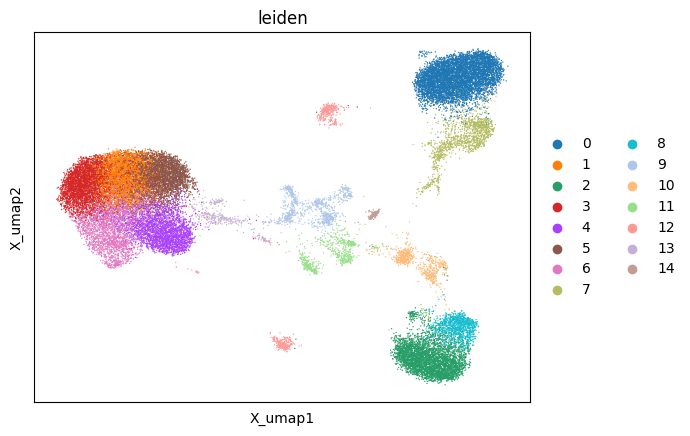

In [47]:
# mu.pl.umap(mudata, frameon=False, 
#             color=['batch_indices', 'panel', 'leiden'],)
mu.pl.embedding(mudata, basis="X_umap", 
                color=['leiden'])

In [57]:
# Plot the embedding, with interested annotation
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax.scatter(mudata)

MuData object with n_obs × n_vars = 32648 × 13663
  obs:	'leiden'
  uns:	'neighbors', 'umap', 'leiden', 'leiden_colors', 'GCAT_neighbors'
  obsm:	'GCAT_embedding', 'X_umap'
  obsp:	'distances', 'connectivities', 'GCAT_neighbors_distances', 'GCAT_neighbors_connectivities'
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'panel_colors', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    prot:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p', 'neighbors'
      obsm:	'X_pca'
      obsp:	'distances', 'connectivities'

In [38]:
# np.save("../data/GraphCrossRNArecon_intersect_hvg_SLN_scCITE.npy", rna_recon)
# np.save("../data/GraphCrossPorteinrecon_intersect_hvg_SLN_scCITE.npy", prot_recon)

In [39]:
# np.save("../data/GraphCrossEmbedding_intersect_hvg_SLN_scCITE.npy", embedding)

In [10]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [12]:
reducer = umap.UMAP(random_state=42)
# UMAP_embedding = reducer.fit_transform(embedding.cpu().numpy())

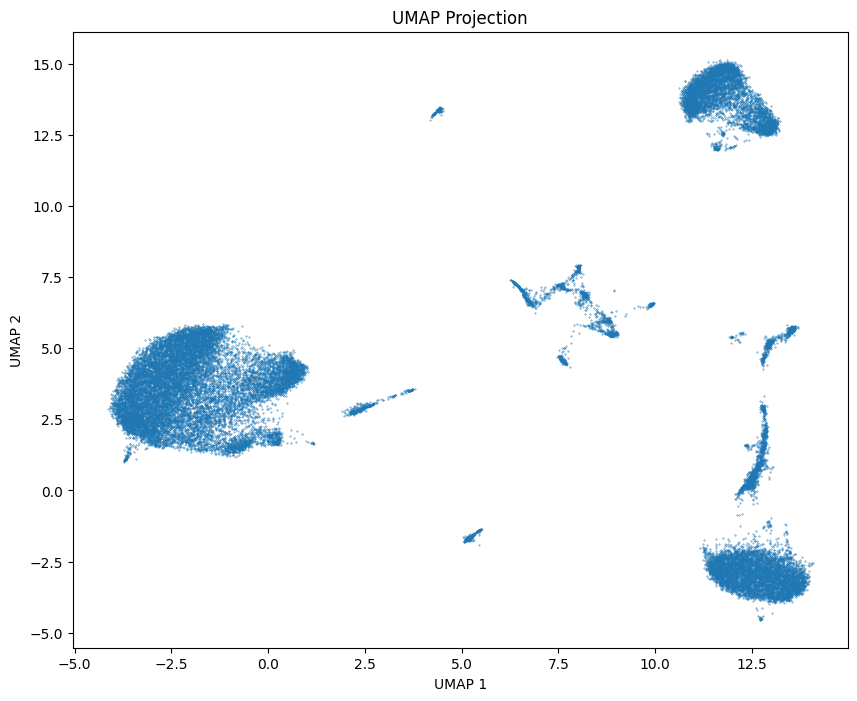

In [42]:
plt.figure(figsize=(10, 8))
plt.scatter(
    UMAP_embedding[:, 0], UMAP_embedding[:, 1], s=0.1
    )
plt.title("UMAP Projection")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

Epoch 1/10 train_loss: 221.70446 val_loss: 25.04636
Epoch 2/10 train_loss: 59.25842 val_loss: 17.61244
Epoch 3/10 train_loss: 48.62587 val_loss: 15.67239
Epoch 4/10 train_loss: 42.16767 val_loss: 13.65454
Epoch 5/10 train_loss: 36.79052 val_loss: 11.64852
Epoch 6/10 train_loss: 31.29320 val_loss: 9.90296
Epoch 7/10 train_loss: 26.47599 val_loss: 8.42477
Epoch 8/10 train_loss: 22.40717 val_loss: 7.18164
Epoch 9/10 train_loss: 19.06965 val_loss: 6.15859
Epoch 10/10 train_loss: 16.30813 val_loss: 5.33195
Best model saved at split 0


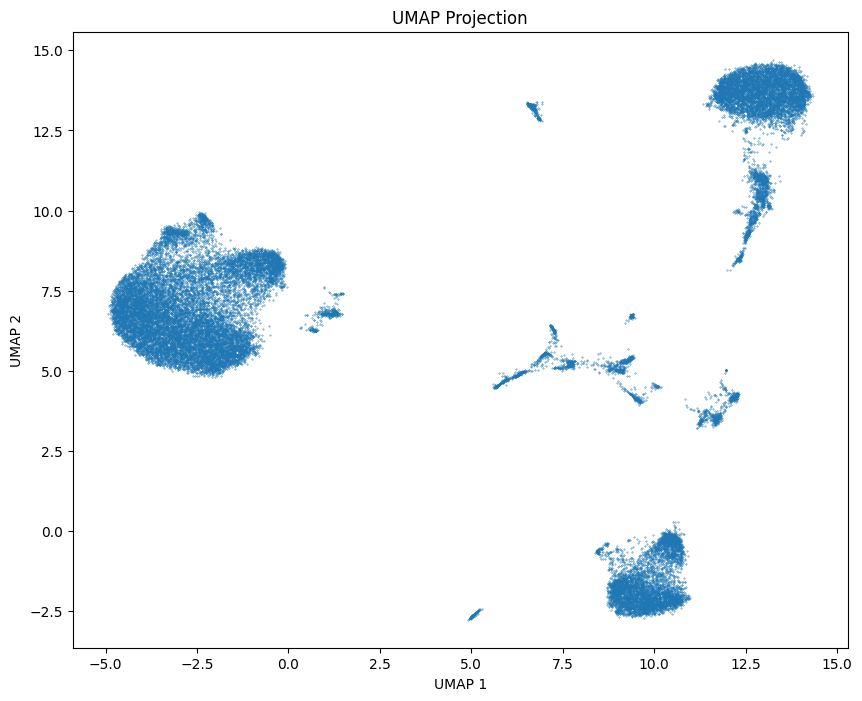

Epoch 1/10 train_loss: 179.10138 val_loss: 20.79376
Epoch 2/10 train_loss: 51.20895 val_loss: 14.74115
Epoch 3/10 train_loss: 40.90349 val_loss: 13.20877
Epoch 4/10 train_loss: 35.95399 val_loss: 11.68148
Epoch 5/10 train_loss: 31.74898 val_loss: 10.18148
Epoch 6/10 train_loss: 27.43340 val_loss: 8.76532
Epoch 7/10 train_loss: 23.65898 val_loss: 7.62510
Epoch 8/10 train_loss: 20.47853 val_loss: 6.62473
Epoch 9/10 train_loss: 17.81032 val_loss: 5.81058
Epoch 10/10 train_loss: 15.59889 val_loss: 5.11885
Best model saved at split 0


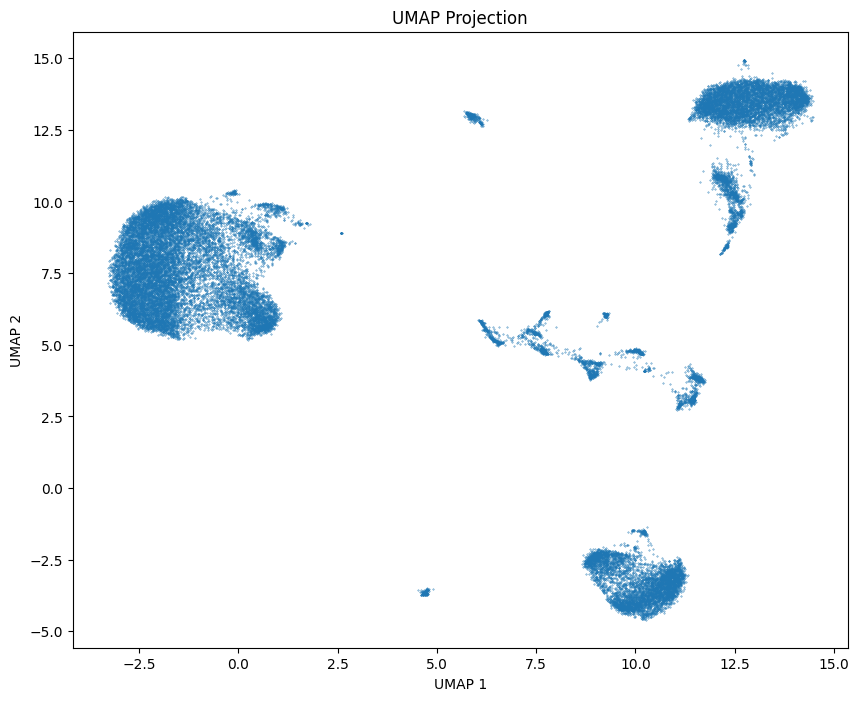

Epoch 1/10 train_loss: 132.78719 val_loss: 15.92445
Epoch 2/10 train_loss: 38.84915 val_loss: 11.63629
Epoch 3/10 train_loss: 32.68204 val_loss: 10.70316
Epoch 4/10 train_loss: 29.25588 val_loss: 9.49530
Epoch 5/10 train_loss: 26.01984 val_loss: 8.42487
Epoch 6/10 train_loss: 23.21662 val_loss: 7.51083
Epoch 7/10 train_loss: 20.63302 val_loss: 6.71309
Epoch 8/10 train_loss: 18.42822 val_loss: 6.03539
Epoch 9/10 train_loss: 16.67277 val_loss: 5.49155
Epoch 10/10 train_loss: 15.13177 val_loss: 5.00451
Best model saved at split 0


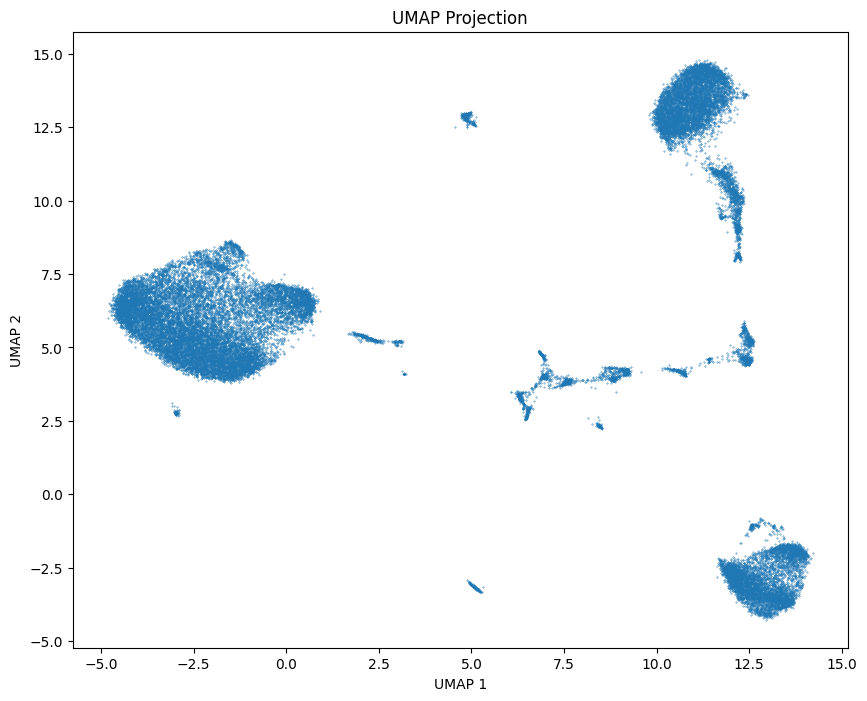

Epoch 1/10 train_loss: 88.77153 val_loss: 11.14817
Epoch 2/10 train_loss: 27.47910 val_loss: 8.54100
Epoch 3/10 train_loss: 23.93476 val_loss: 7.83200
Epoch 4/10 train_loss: 21.66744 val_loss: 7.14064
Epoch 5/10 train_loss: 19.95602 val_loss: 6.63107
Epoch 6/10 train_loss: 18.55954 val_loss: 6.13716
Epoch 7/10 train_loss: 17.23670 val_loss: 5.72377
Epoch 8/10 train_loss: 16.01386 val_loss: 5.31544
Epoch 9/10 train_loss: 14.94827 val_loss: 4.97625
Epoch 10/10 train_loss: 14.00874 val_loss: 4.66514
Best model saved at split 0


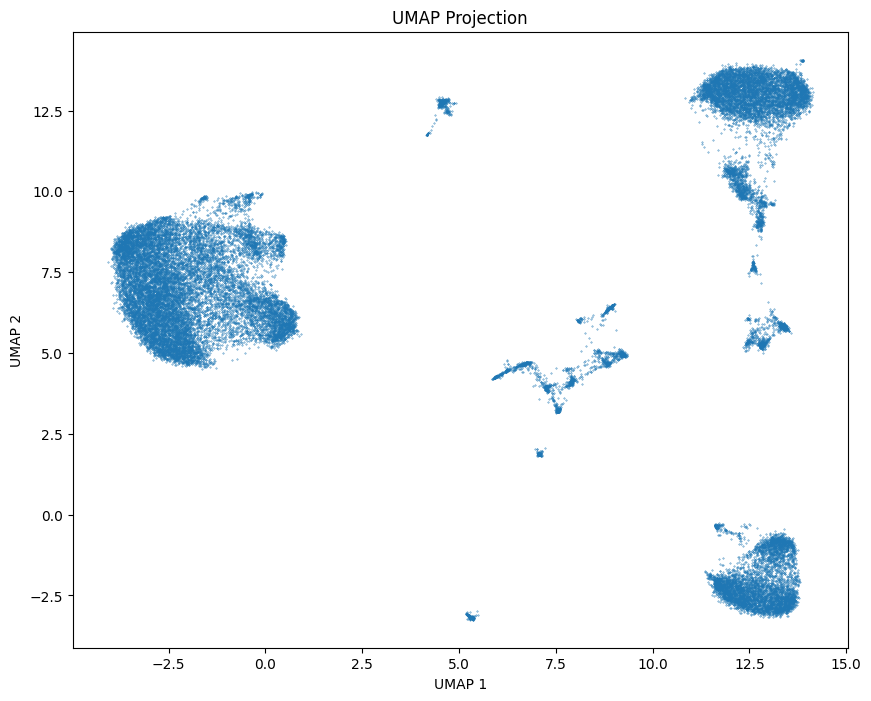

In [13]:
# check the umap visualization when alpha=0.1 to alpha=0.9
for alpha in range(1, 9, 2):
    trainer = Trainer( 
        training_data,
        model_choice=model_choice,
        rna_input_dim=rna_input_dim,
        prot_input_dim=prot_input_dim,
        hidden_dim=hidden_dim,
        embedding_dim=embedding_dim,
        heads=heads,
        num_blocks=num_blocks,
        batch_size=batch_size,
        lr=lr,
        epochs=epochs,
        mask_ratio=mask_ratio,
        permute=False,
        preserve_rate=preserve_rate,
        num_splits=num_splits,
        device=device,
        alpha=alpha/10,
        beta=beta,
    )
    trainer.train(plot_loss=False)
    embedding = trainer.get_embedding(scdata)
    UMAP_embedding = reducer.fit_transform(embedding.cpu().numpy())
    plt.figure(figsize=(10, 8))
    plt.scatter(
        UMAP_embedding[:, 0], UMAP_embedding[:, 1], s=0.1
        )
    plt.title(f"UMAP Projection - alpha: {alpha}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

Epoch 1/10 train_loss: 88.85593 val_loss: 11.37204
Epoch 2/10 train_loss: 29.11453 val_loss: 8.57054
Epoch 3/10 train_loss: 24.18892 val_loss: 7.96753
Epoch 4/10 train_loss: 22.24333 val_loss: 7.34684
Epoch 5/10 train_loss: 20.65036 val_loss: 6.86724
Epoch 6/10 train_loss: 19.34682 val_loss: 6.49325
Epoch 7/10 train_loss: 18.19398 val_loss: 6.06118
Epoch 8/10 train_loss: 17.11890 val_loss: 5.70157
Epoch 9/10 train_loss: 16.12340 val_loss: 5.41056
Epoch 10/10 train_loss: 15.30699 val_loss: 5.15062
Best model saved at split 0


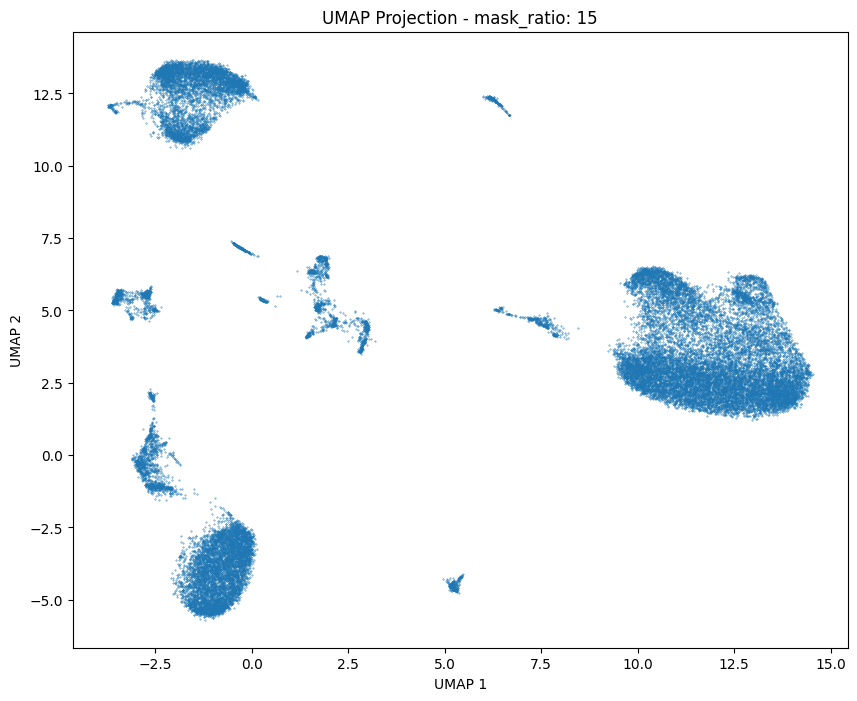

Epoch 1/10 train_loss: 90.53917 val_loss: 11.32329
Epoch 2/10 train_loss: 28.65538 val_loss: 8.62153
Epoch 3/10 train_loss: 24.25748 val_loss: 8.01281
Epoch 4/10 train_loss: 22.33079 val_loss: 7.37025
Epoch 5/10 train_loss: 20.72094 val_loss: 6.90354
Epoch 6/10 train_loss: 19.32388 val_loss: 6.42844
Epoch 7/10 train_loss: 18.01966 val_loss: 5.96272
Epoch 8/10 train_loss: 16.78930 val_loss: 5.59909
Epoch 9/10 train_loss: 15.76129 val_loss: 5.28036
Epoch 10/10 train_loss: 14.84307 val_loss: 4.97053
Best model saved at split 0


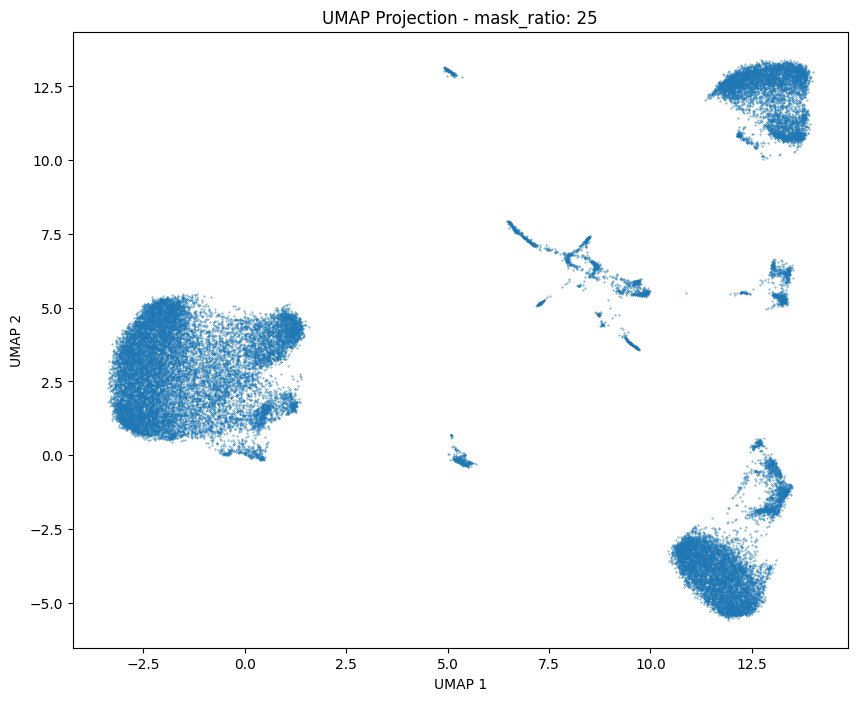

Epoch 1/10 train_loss: 90.82069 val_loss: 11.42772
Epoch 2/10 train_loss: 28.95509 val_loss: 8.63809
Epoch 3/10 train_loss: 24.05776 val_loss: 7.92773
Epoch 4/10 train_loss: 22.09254 val_loss: 7.35219
Epoch 5/10 train_loss: 20.56160 val_loss: 6.83471
Epoch 6/10 train_loss: 19.18510 val_loss: 6.32611
Epoch 7/10 train_loss: 17.81903 val_loss: 5.91056
Epoch 8/10 train_loss: 16.58317 val_loss: 5.49803
Epoch 9/10 train_loss: 15.51816 val_loss: 5.17052
Epoch 10/10 train_loss: 14.57355 val_loss: 4.87298
Best model saved at split 0


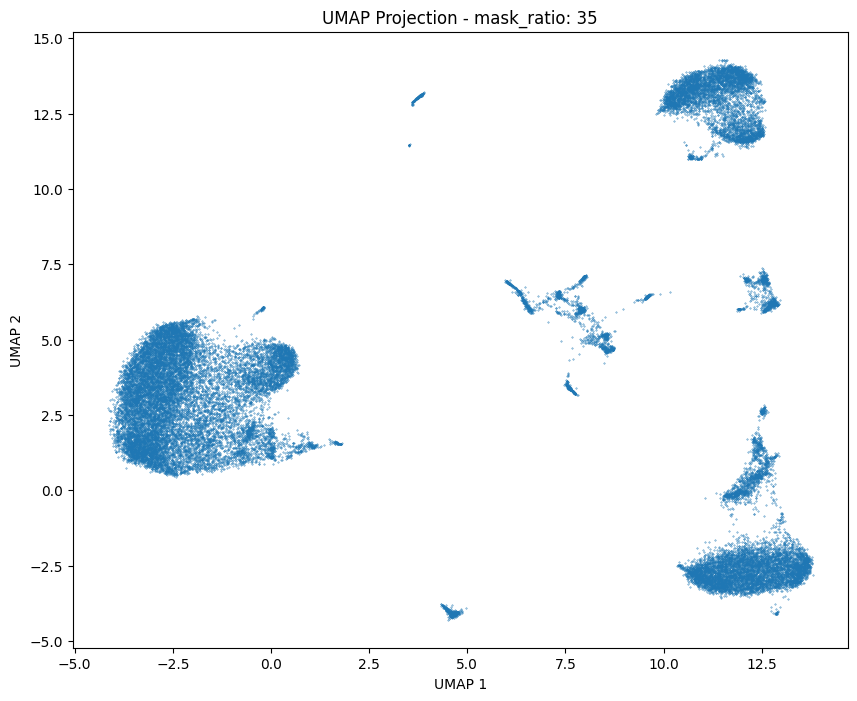

Epoch 1/10 train_loss: 88.36314 val_loss: 11.27888
Epoch 2/10 train_loss: 28.24487 val_loss: 8.55861
Epoch 3/10 train_loss: 24.00673 val_loss: 7.86904
Epoch 4/10 train_loss: 21.69822 val_loss: 7.15269
Epoch 5/10 train_loss: 20.01857 val_loss: 6.62869
Epoch 6/10 train_loss: 18.54875 val_loss: 6.11426
Epoch 7/10 train_loss: 17.10364 val_loss: 5.66394
Epoch 8/10 train_loss: 15.85005 val_loss: 5.25412
Epoch 9/10 train_loss: 14.72830 val_loss: 4.89313
Epoch 10/10 train_loss: 13.81719 val_loss: 4.62787
Best model saved at split 0


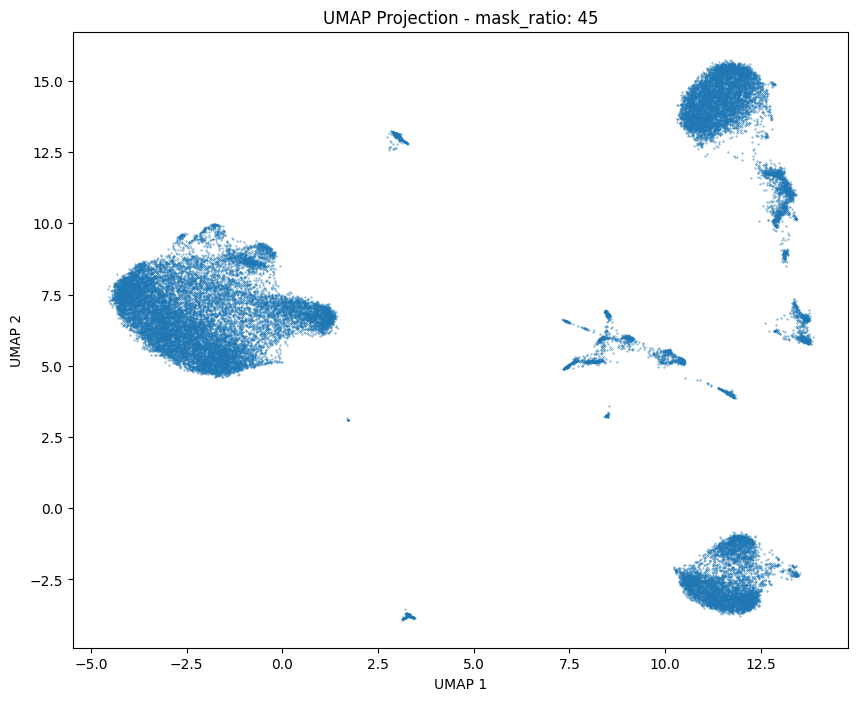

Epoch 1/10 train_loss: 91.87628 val_loss: 11.14674
Epoch 2/10 train_loss: 27.60329 val_loss: 8.54871
Epoch 3/10 train_loss: 23.70801 val_loss: 7.78404
Epoch 4/10 train_loss: 21.60431 val_loss: 7.12172
Epoch 5/10 train_loss: 19.92448 val_loss: 6.57852
Epoch 6/10 train_loss: 18.38934 val_loss: 6.07031
Epoch 7/10 train_loss: 16.97578 val_loss: 5.60350
Epoch 8/10 train_loss: 15.72315 val_loss: 5.20836
Epoch 9/10 train_loss: 14.63244 val_loss: 4.86549
Epoch 10/10 train_loss: 13.74287 val_loss: 4.58741
Best model saved at split 0


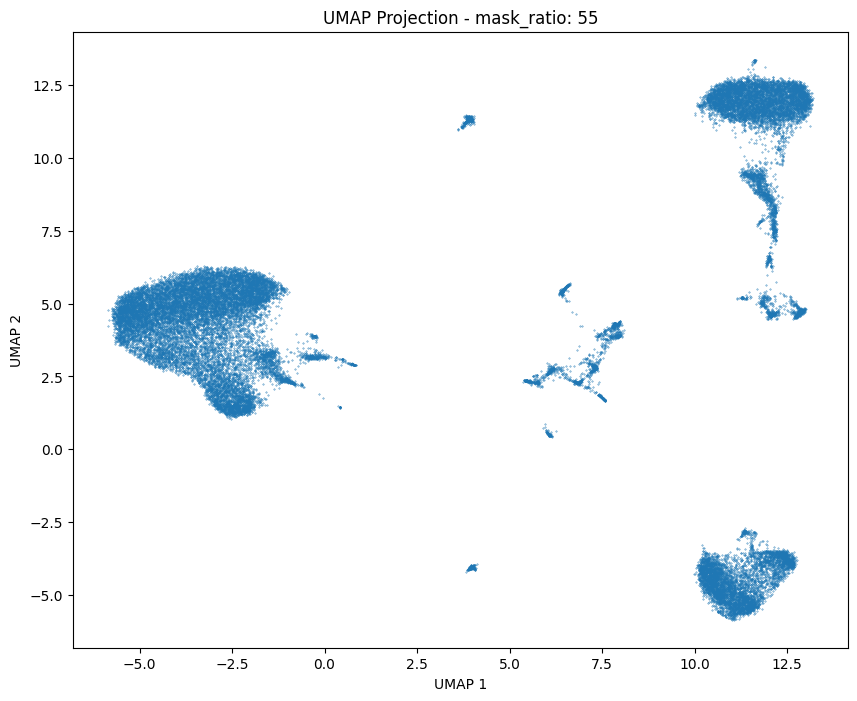

Epoch 1/10 train_loss: 91.33841 val_loss: 11.23942
Epoch 2/10 train_loss: 27.92614 val_loss: 8.54362
Epoch 3/10 train_loss: 23.79891 val_loss: 7.81206
Epoch 4/10 train_loss: 21.63958 val_loss: 7.15198
Epoch 5/10 train_loss: 19.96640 val_loss: 6.57464
Epoch 6/10 train_loss: 18.43947 val_loss: 6.08346
Epoch 7/10 train_loss: 17.07648 val_loss: 5.64982
Epoch 8/10 train_loss: 15.85699 val_loss: 5.26346
Epoch 9/10 train_loss: 14.82005 val_loss: 4.93973
Epoch 10/10 train_loss: 13.90492 val_loss: 4.64584
Best model saved at split 0


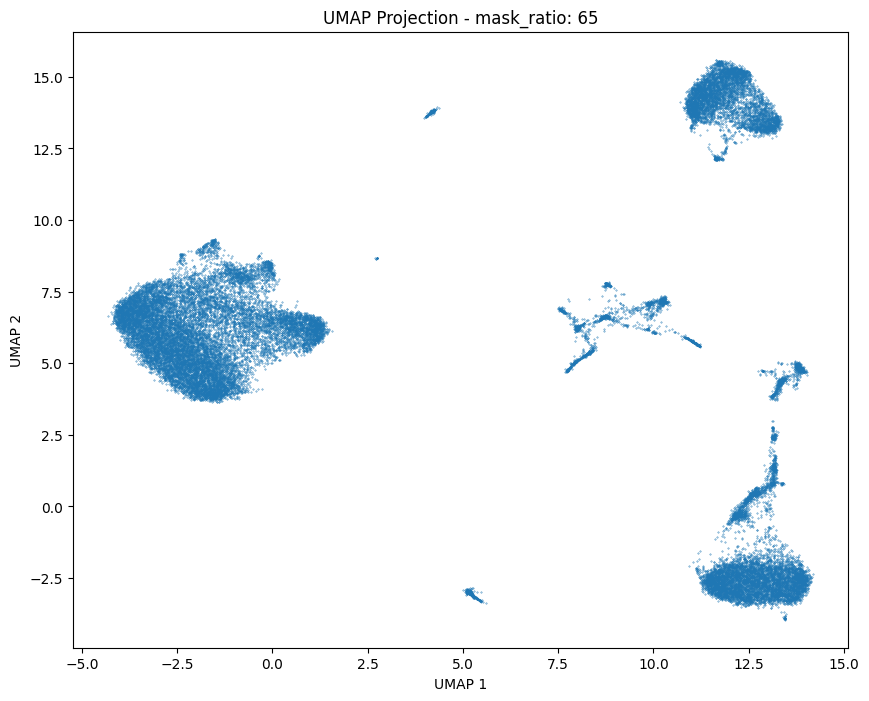

Epoch 1/10 train_loss: 87.91703 val_loss: 11.26749
Epoch 2/10 train_loss: 27.87318 val_loss: 8.51060
Epoch 3/10 train_loss: 23.68912 val_loss: 7.76536
Epoch 4/10 train_loss: 21.60320 val_loss: 7.16623
Epoch 5/10 train_loss: 20.02747 val_loss: 6.61517
Epoch 6/10 train_loss: 18.54035 val_loss: 6.13265
Epoch 7/10 train_loss: 17.15760 val_loss: 5.66730
Epoch 8/10 train_loss: 15.92041 val_loss: 5.29625
Epoch 9/10 train_loss: 14.84507 val_loss: 4.94027
Epoch 10/10 train_loss: 13.91871 val_loss: 4.65661
Best model saved at split 0


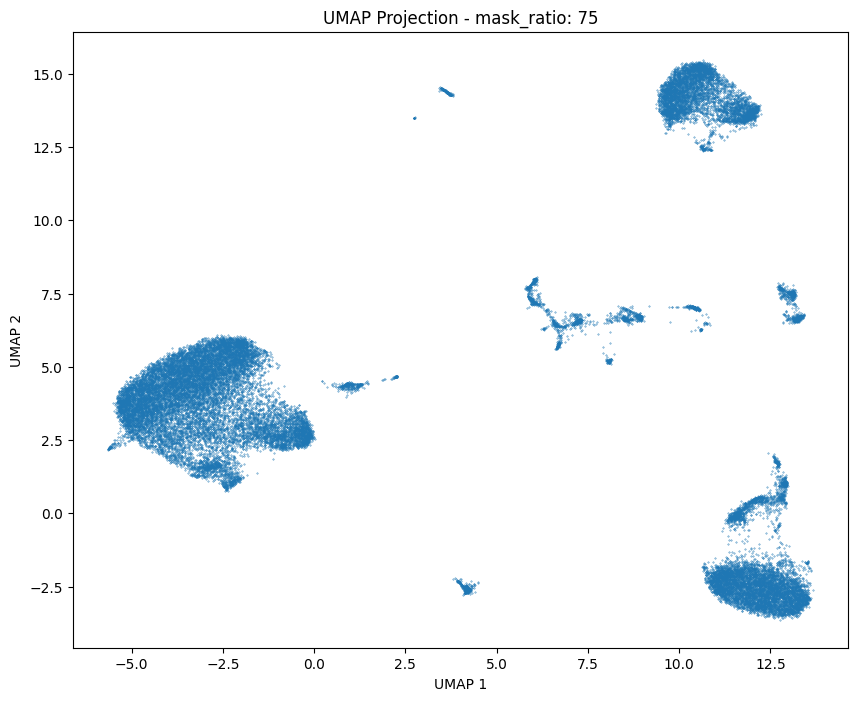

Epoch 1/10 train_loss: 86.63668 val_loss: 11.20649
Epoch 2/10 train_loss: 28.01354 val_loss: 8.58353
Epoch 3/10 train_loss: 23.99624 val_loss: 7.87106
Epoch 4/10 train_loss: 21.76010 val_loss: 7.18053
Epoch 5/10 train_loss: 20.04469 val_loss: 6.62817
Epoch 6/10 train_loss: 18.52306 val_loss: 6.11685
Epoch 7/10 train_loss: 17.08534 val_loss: 5.67124
Epoch 8/10 train_loss: 15.88023 val_loss: 5.29049
Epoch 9/10 train_loss: 14.86324 val_loss: 4.96183
Epoch 10/10 train_loss: 13.96277 val_loss: 4.68213
Best model saved at split 0


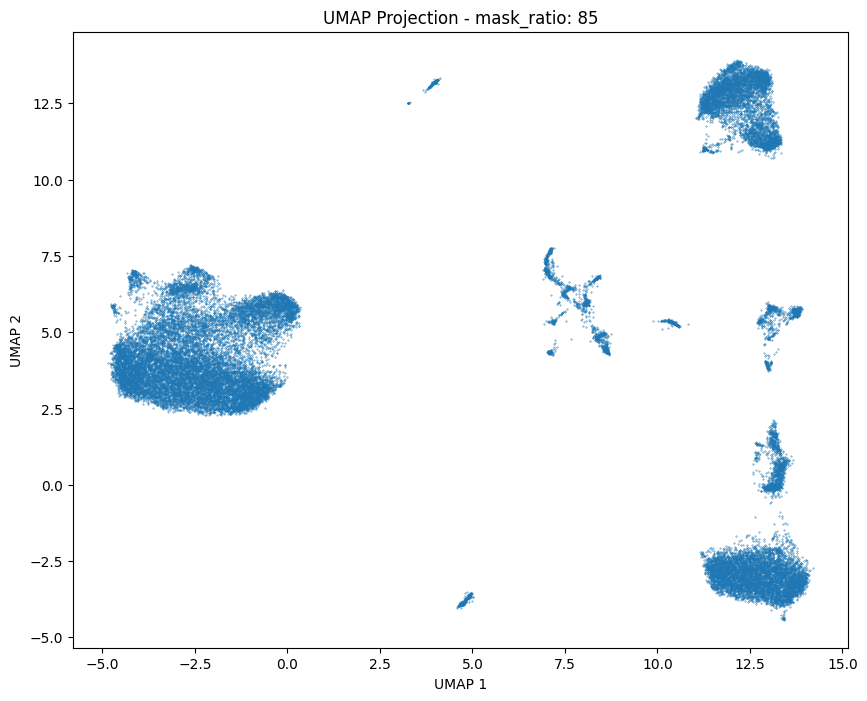

In [14]:
# check the umap visualization when alpha=0.1 to alpha=0.9
for mask_ratio in range(15, 95, 10):
    trainer = Trainer( 
        training_data,
        model_choice=model_choice,
        rna_input_dim=rna_input_dim,
        prot_input_dim=prot_input_dim,
        hidden_dim=hidden_dim,
        embedding_dim=embedding_dim,
        heads=heads,
        num_blocks=num_blocks,
        batch_size=batch_size,
        lr=lr,
        epochs=epochs,
        mask_ratio=mask_ratio/100,
        permute=False,
        preserve_rate=preserve_rate,
        num_splits=num_splits,
        device=device,
        alpha=0.7,
        beta=beta,
    )
    trainer.train(plot_loss=False)
    embedding = trainer.get_embedding(scdata)
    UMAP_embedding = reducer.fit_transform(embedding.cpu().numpy())
    plt.figure(figsize=(10, 8))
    plt.scatter(
        UMAP_embedding[:, 0], UMAP_embedding[:, 1], s=0.1
        )
    plt.title(f"UMAP Projection - mask_ratio: {mask_ratio}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

In [19]:
mdata = mu.MuData({
    "rna": rna_adata_pool,
    "protein": protein_adata_intersect,
})
mdata

MuData object with n_obs × n_vars = 32648 × 13663
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

## With whole transcriptomics

In [3]:
mdata = mu.read_h5mu(f"{save_path}scCITE_combine.h5mu")
mdata

MuData object with n_obs × n_vars = 32648 × 13760
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 207
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [4]:
mdata.update()

In [5]:
gene_dict = {
    "Atn1-1": "Atn1",
    "Dancr-1": "Dancr",
    "Gbp6-1": "Gbp6",
    "Hist2h2bb-1": "Hist2h2bb",
    "Itgam-1": "Itgam",
    "Pcdhga8-1": "Pcdhga8",
    "Smim20-1": "Smim20",
    "U2af1l4-1": "U2af1l4",
}

In [6]:
# replace var_names using gene_dict
for k, v in gene_dict.items():
    mdata.mod['rna'].var_names = mdata.mod['rna'].var_names.str.replace(k, v)

In [7]:
# find the repeated gene names and only keep the first one
gene_names = mdata.mod['rna'].var_names
gene_names = pd.Series(gene_names)
# gene_names[gene_names.duplicated(keep=False)]
gene_names = gene_names[~gene_names.duplicated(keep='first')]
gene_names

0                Mrpl15
1                Lypla1
2                 Tcea1
3               Atp6v1h
4                Rb1cc1
              ...      
13548        AC125149.3
13549        AC168977.1
13550              PISD
13551             DHRSX
13552    CAAA01147332.1
Name: index, Length: 13548, dtype: object

In [8]:
mdata.mod["rna"] = mdata.mod['rna'][:, gene_names.index]
mdata

MuData object with n_obs × n_vars = 32648 × 13760
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 207
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [11]:
gtf_path = "/DATA/User/wuxinchao/st_cite_data/ref/Mus_musculus.GRCm38.84.gtf"
geneVocab = GeneVocab(mdata.mod['rna'])
geneVocab.sort_by_genomic_position(gtf_path)
sc_rna_data = geneVocab.align_features(mdata.mod['rna'])
sc_prot_data = mdata.mod['protein'][mdata.mod['rna'].obs_names]
sc_rna_data.obsp = mdata.mod['rna'].obsp
# sc_prot_data.var_names = sc_prot_data.var_names.str.split("_").str[-2]

In [12]:
model_choice = "Graph Cross Attention"

rna_input_dim = sc_rna_data.X.shape[1]
prot_input_dim = sc_prot_data.X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

scData = SinglecellData(mdata, geneVocab)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData.data)

In [13]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=20,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 146.27597 val_loss: 24.06301
Epoch 2/20 train_loss: 53.28050 val_loss: 12.31422
Epoch 3/20 train_loss: 31.94877 val_loss: 9.76670
Epoch 4/20 train_loss: 28.22417 val_loss: 9.54354
Epoch 5/20 train_loss: 27.86188 val_loss: 9.51136
Epoch 6/20 train_loss: 27.74926 val_loss: 9.46362
Epoch 7/20 train_loss: 27.54523 val_loss: 9.35885
Epoch 8/20 train_loss: 27.19448 val_loss: 9.23387
Epoch 9/20 train_loss: 26.56117 val_loss: 8.97669
Epoch 10/20 train_loss: 25.77815 val_loss: 8.75822
Epoch 11/20 train_loss: 25.16904 val_loss: 8.57291
Epoch 12/20 train_loss: 24.70059 val_loss: 8.45274
Epoch 13/20 train_loss: 24.32517 val_loss: 8.37154
Epoch 14/20 train_loss: 24.11567 val_loss: 8.31517
Epoch 15/20 train_loss: 23.90126 val_loss: 8.26958
Epoch 16/20 train_loss: 23.76920 val_loss: 8.21635
Epoch 17/20 train_loss: 23.62305 val_loss: 8.15923
Epoch 18/20 train_loss: 23.50937 val_loss: 8.13411
Epoch 19/20 train_loss: 23.42136 val_loss: 8.11693
Epoch 20/20 train_loss: 23.29162 val_

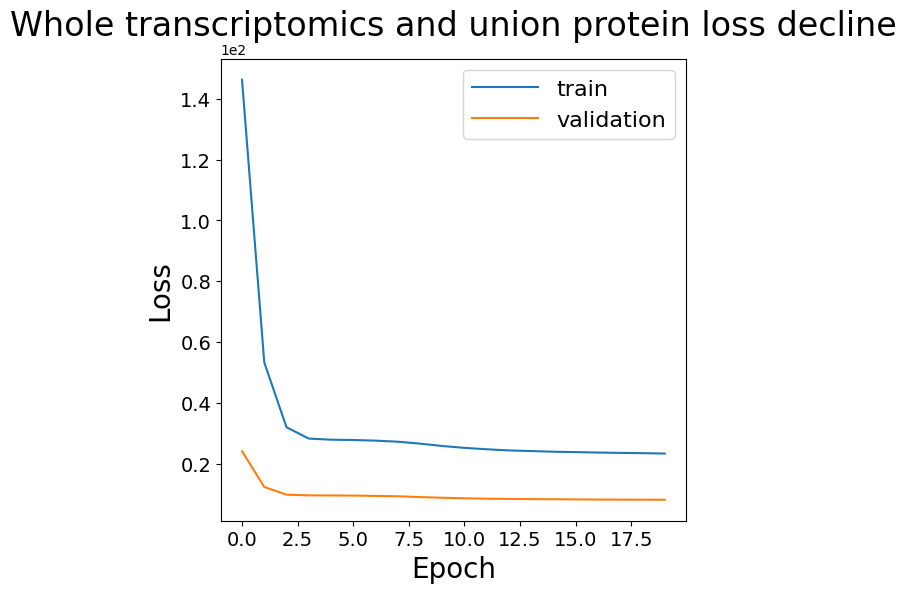

In [14]:
# plot the training and validation loss
plt.figure(figsize=(6,6))
plt.plot(train_losses[0], label="train")
plt.plot(val_losses[0], label="validation")
plt.title("Whole transcriptomics and union protein loss decline", fontsize=24)
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16, 'weight': 'normal'}, handlelength=3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("scCITE_whole_trans_training_union_loss.png")

In [15]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/scCITE_seq_whole_union.pt")

In [16]:
model = trainer.best_model

In [17]:
adj_mtx = rna_adata_pool_subset.obsp['connectivities'].toarray()
edge_index = adj_mtx.nonzero()
edge_index = np.array(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((sc_rna_data.X, sc_prot_data.X), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

NameError: name 'rna_adata_pool_subset' is not defined

In [ ]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [122]:
from scipy.sparse import csr_matrix, save_npz

rna_recon = csr_matrix(rna_recon)
prot_recon = csr_matrix(prot_recon)
save_npz("../data/GraphCrossRNArecon_combined_whole_trans_intersect_SLN_scCITE.npz", rna_recon)
save_npz("../data/GraphCrossPorteinrecon_combined_whole_trans_intersect_SLN_scCITE.npz", prot_recon)
# np.save("../data/GraphCrossRNArecon_combined_intersect_SLN_scCITE.npy", rna_recon)
# np.save("../data/GraphCrossPorteinrecon_combined_intersect_SLN_scCITE.npy", prot_recon)

In [ ]:
np.save("../data/GraphCrossEmbedding_combined_whole_trans_union_SLN_scCITE.npy", embedding)

In [125]:
mdata

MuData object with n_obs × n_vars = 32648 × 13658
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

# spatial

## spCITE spleen mouse

In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scvi

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
mdata = mu.read_h5mu("/home/wuxinchao/data/st_cite_data/spatial_cite_data/mouse_spleen_spCITE.h5mu")

In [3]:
rna_adata = mdata.mod['rna']
prot_adata = mdata.mod["prot"]

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


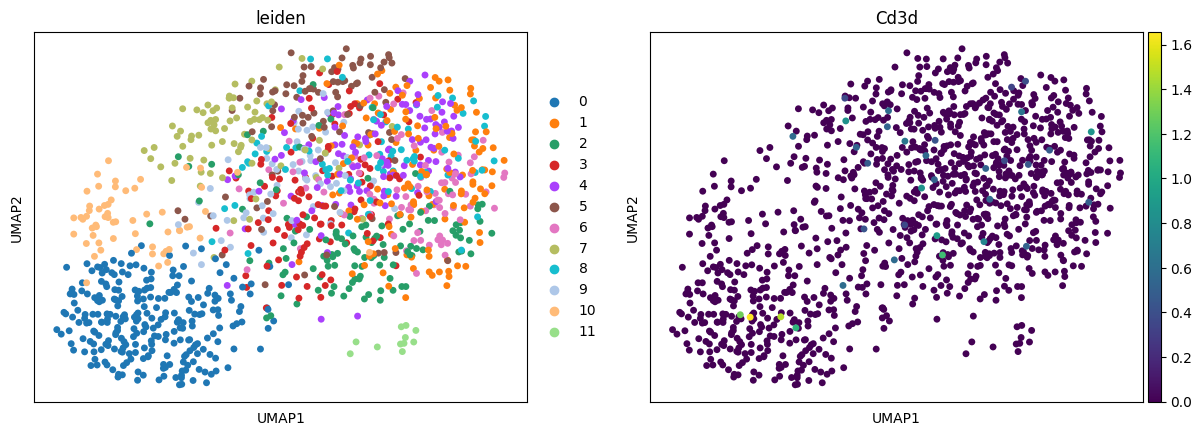

In [149]:
rna_adata.layers["counts"] = rna_adata.X.copy()
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
rna_adata.obs_names_make_unique()

sc.pp.highly_variable_genes(
    rna_adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    # batch_key="batch",
    layer="counts",
)
rna_adata.raw = rna_adata
sc.pp.scale(rna_adata, max_value=10)
sc.tl.pca(rna_adata, svd_solver='arpack')
sc.pp.neighbors(rna_adata, n_neighbors=10, n_pcs=50)

sc.tl.leiden(rna_adata, resolution=1)
sc.tl.umap(rna_adata, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna_adata, color=['leiden','Cd3d'])

In [147]:
# int(rna_adata.obs["x"]), int(rna_adata.obs["y"])
rna_adata.obs["x"] = rna_adata.obs["x"].astype(float)
rna_adata.obs["y"] = rna_adata.obs["y"].astype(float)
rna_adata.obsm["spatial"] = rna_adata.obs[["x", "y"]].values

In [154]:
prot_adata.obs[["x", "y"]] = rna_adata.obs[["x", "y"]]

In [155]:
prot_adata.obs["x"] = prot_adata.obs["x"].astype(float)
prot_adata.obs["y"] = prot_adata.obs["y"].astype(float)
prot_adata.obsm["spatial"] = prot_adata.obs[["x", "y"]].values

In [283]:
mdata.write("/home/wuxinchao/data/st_cite_data/spatial_cite_data/mouse_spleen_spCITE.h5mu")

In [7]:
highly_variable = pd.read_csv(f"{save_path}/scCITE_hvg.csv")

In [8]:
# rna_adata[:,highly_variable.iloc[:,0]]
rna_adata_hvg_transfer = rna_adata[:, rna_adata.var_names.isin(highly_variable.iloc[:,0].to_list())]
rna_adata_hvg_transfer

View of AnnData object with n_obs × n_vars = 1222 × 3210
    obs: 'n_genes', 'x', 'y', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_proximity'

In [9]:
# new_exp = np.zeros_like((rna_adata_hvg_transfer.shape[0], len(highly_variable)-1))
highly_variable.index = highly_variable.iloc[:,0]
highly_variable = highly_variable.T
highly_variable = highly_variable.drop('0')

In [10]:
for i, gene_name in enumerate(rna_adata_hvg_transfer.var_names):
    highly_variable[gene_name] = rna_adata_hvg_transfer.X[:,i]
# highly_variable["Akap12"] = rna_adata_hvg_transfer.X[:,2]

In [11]:
highly_variable = highly_variable.fillna(0)

In [12]:
prot_adata.layers["counts"] = prot_adata.X.copy()

In [13]:
prot_adata.X = prot_adata.layers["counts"].copy()
sc.pp.normalize_total(prot_adata, target_sum=1e4)
sc.pp.log1p(prot_adata)

In [14]:
# ''.join(filter(str.isalnum, prot_adata.var_names[prot_adata.var_names.str.contains("CD")].to_list()[0].lower()))
list1 = [i[:-1] for i in protein_adata_intersect.var_names.str.replace("ADT_", "").str.split("_")]
list2 = prot_adata.var_names.to_list()
result = {}
for i, protein1 in enumerate(list1):
    for j, protein2 in enumerate(list2):
        # print(protein1), print(protein2)
        if ''.join(filter(str.isalnum, protein1[0].lower())) in ''.join(filter(str.isalnum, protein2.lower())):
            # result[protein1[0]] = f"index of list 1: {i} (name in list 1: {protein1}), index of list 2: {j} (name in list 2: {protein2})"
            result[protein1[0]] = [i, j]
            break

In [16]:
new_prot_exp = pd.DataFrame(columns = protein_adata_intersect.var_names)
for protein in result:
    new_prot_exp[new_prot_exp.columns[result[protein][0]]] = prot_adata.X[:, result[protein][1]]
new_prot_exp = new_prot_exp.fillna(0)

In [264]:
import numpy as np

# Function to calculate Euclidean distance between two spots
def euclidean_distance(s_i, s_j):
    return np.sqrt((s_i[0] - s_j[0])**2 + (s_i[1] - s_j[1])**2)

# Function to calculate the weight based on the exponential decay function
def exponential_decay(d, alpha):
    return np.exp(-alpha * d)

# Function to build the weighted adjacency matrix
def build_adjacency_matrix(spots, alpha):
    n = len(spots)  # Number of spots
    W = np.zeros((n, n))  # Initialize the adjacency matrix
    
    # Iterate through each pair of spots to fill the adjacency matrix
    for i in range(n):
        for j in range(n):
            if i != j:  # No self-connections
                d = euclidean_distance(spots[i], spots[j])
                W[i, j] = exponential_decay(d, alpha)
    
    return W

In [274]:
rna_adata.obsp["spatial_proximity"] = build_adjacency_matrix(prot_adata.obsm["spatial"], 0.5)

In [17]:
highly_variable.shape, new_prot_exp.shape

((1222, 4000), (1222, 110))

In [18]:
rna_input = highly_variable.values[:, :-1]
prot_input = new_prot_exp.values

In [52]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_input.shape[1]
prot_input_dim = prot_input.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = rna_adata.obsp['spatial_proximity']
edge_index = adj_mtx.nonzero()
edge_index = np.array(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((rna_input, prot_input), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 1
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [73]:
scData

Data(x=[1222, 4109], edge_index=[2, 1492062], train_mask=[1222], val_mask=[1222], test_mask=[1222])

In [20]:
# loading the pre-trained model
from model import GraphCrossAttn

model = GraphCrossAttn(
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
).to(device)

# load the pre-trained model
# model.load_state_dict(torch.load("../save_model/scCITE_intersect_hvg.pt")["model"])

<All keys matched successfully>

In [53]:
training_data

Data(x=[1222, 4109], edge_index=[2, 1492062], train_mask=[1222], val_mask=[1222], test_mask=[1222])

In [60]:
import importlib
import sys

importlib.reload(sys.modules['train'])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [63]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.75,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses = trainer.fine_tune(model=model, epochs=10, 
                    model_name="scCITE_intersect_hvg.pt", save_name="sc_spCITE_spleen_mouse_transfer.pt")

Epoch 1/10, Loss: 3.179643233617147
Epoch 2/10, Loss: 2.289055426915487
Epoch 3/10, Loss: 1.7865444421768188
Epoch 4/10, Loss: 1.7076302766799927
Epoch 5/10, Loss: 1.694178581237793
Epoch 6/10, Loss: 1.6648138761520386
Epoch 7/10, Loss: 1.6124885082244873
Epoch 8/10, Loss: 1.5646273692448933
Epoch 9/10, Loss: 1.5310066143671672
Epoch 10/10, Loss: 1.5077422857284546


In [64]:
model.load_state_dict(torch.load("../save_model/best_sc_spCITE_spleen_mouse_transfer.pt")["model"])

<All keys matched successfully>

In [65]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [97]:
# df.DataFrame(mdata.mod['rna'].var[mdata.mod['rna'].var["highly_variable"]].index).to_csv("../data/scCITE_combined_hvg_list.csv")

In [67]:
np.save("../data/GraphCrossRNArecon_intersect_hvg_mouse_spleen_spCITE.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_intersect_hvg_mouse_spleen_spCITE.npy", prot_recon)

In [68]:
np.save("../data/GraphCrossEmbedding_intersect_hvg_mouse_spleen_sp.npy", embedding)

### sp integrate

In [75]:
rna_adata, prot_adata

(AnnData object with n_obs × n_vars = 1222 × 16033
     obs: 'n_genes', 'x', 'y', 'leiden'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'connectivities', 'distances', 'spatial_proximity',
 AnnData object with n_obs × n_vars = 1222 × 193
     obs: 'n_genes', 'x', 'y'
     var: 'n_cells'
     uns: 'log1p'
     obsm: 'spatial'
     layers: 'counts')

In [77]:
rna_adata_subset = rna_adata[:,rna_adata.var['highly_variable']]
rna_adata_subset

View of AnnData object with n_obs × n_vars = 1222 × 4000
    obs: 'n_genes', 'x', 'y', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_proximity'

In [78]:
rna_input = rna_adata_subset.X
prot_input = prot_adata.X

In [81]:
import torch

def build_adjacency_matrix_torch(spots, alpha, T=0.005, device='cuda'):
    spots = torch.tensor(spots, dtype=torch.float32, device=device)
    # Calculate the pairwise Euclidean distances using broadcasting
    diff = spots[:, None, :] - spots[None, :, :]
    distances = torch.sqrt(torch.sum(diff**2, dim=-1))
    
    # Apply the exponential decay function to the distances
    W = torch.exp(-alpha * distances)
    W.masked_fill_(W<T, 0)
    
    # Zero out the diagonal (no self-connections)
    W.fill_diagonal_(0)
    
    return W

In [85]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_input.shape[1]
prot_input_dim = prot_input.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_adata_subset.obsm["spatial"], alpha=0.5)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((rna_input, prot_input), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [88]:
import importlib
import sys

importlib.reload(sys.modules["train"])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [89]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()
# 32s

Epoch 1/20 train_loss: 22.51069 val_loss: 7.36853
Epoch 2/20 train_loss: 21.97413 val_loss: 7.06932
Epoch 3/20 train_loss: 21.05295 val_loss: 6.61205
Epoch 4/20 train_loss: 19.60207 val_loss: 5.93934
Epoch 5/20 train_loss: 17.62378 val_loss: 5.24630
Epoch 6/20 train_loss: 15.58553 val_loss: 4.71480
Epoch 7/20 train_loss: 13.69946 val_loss: 4.11663
Epoch 8/20 train_loss: 11.90050 val_loss: 3.55900
Epoch 9/20 train_loss: 10.36113 val_loss: 3.14705
Epoch 10/20 train_loss: 9.05988 val_loss: 2.82881
Epoch 11/20 train_loss: 8.09120 val_loss: 2.57403
Epoch 12/20 train_loss: 7.42407 val_loss: 2.38125
Epoch 13/20 train_loss: 6.94001 val_loss: 2.25360
Epoch 14/20 train_loss: 6.57417 val_loss: 2.17295
Epoch 15/20 train_loss: 6.32847 val_loss: 2.10913
Epoch 16/20 train_loss: 6.17013 val_loss: 2.08335
Epoch 17/20 train_loss: 6.06612 val_loss: 2.05556
Epoch 18/20 train_loss: 6.00650 val_loss: 2.03090
Epoch 19/20 train_loss: 5.93739 val_loss: 2.01970
Epoch 20/20 train_loss: 5.87652 val_loss: 2.01176


In [90]:
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/spCITE_seq_integrate.pt")

In [92]:
# model.load_state_dict(torch.load("../save_model/spCITE_seq_integrate.pt")["model"])
model = trainer.best_model

In [93]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [94]:
np.save("../data/GraphCrossRNArecon_human_thymus_spCITE_hvg.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_human_thymus_spCITE_hvg.npy", prot_recon)
np.save("../data/GraphCrossEmbedding_human_thymus_spCITE_hvg.npy", embedding)

In [96]:
%whos

Variable                       Type               Data/Info
-----------------------------------------------------------
Data                           type               <class 'torch_geometric.data.data.Data'>
GeneVocab                      type               <class 'dataset.GeneVocab'>
GraphCrossAttn                 type               <class 'model.GraphCrossAttn'>
RandomNodeSplit                ABCMeta            <class 'torch_geometric.t<...>e_split.RandomNodeSplit'>
SinglecellData                 type               <class 'dataset.SinglecellData'>
Trainer                        type               <class 'train.Trainer'>
ad                             module             <module 'anndata' from '/<...>ges/anndata/__init__.py'>
adj_mtx                        Tensor             tensor([[0.0000, 0.0000, <...>\n       device='cuda:0')
alpha                          float              0.4
batch_size                     int                256
beta                           float           